In [3]:
import numpy as np
from matplotlib import pyplot as plt

# Chebyshev Approximation

Let's see if we can successfully estimate a function and its integral using Chebyshev polynomials.

In [7]:
def pdf(x):
    return np.exp(-x**2 * 8)

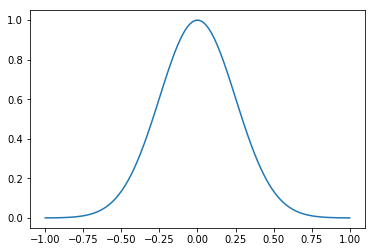

In [8]:
x = np.linspace(-1,1,100)
plt.plot(x,pdf(x))

We'll start out on `[-1,1]` since this is the natural Chebyshev interval, then we'll deal with changes in variables.

I don't see a function in numpy for generating a grid of Chebyshev nodes, so let's make one.

In [10]:
def chebnodes(a,b,n):
    assert a<b
    return np.array([1/2*((a+b)+(b-a)*np.cos((2*k-1)*np.pi/(2*n))) for k in range(1,n+1)])

In [11]:
chebnodes(-1,1,10)

array([ 0.98768834,  0.89100652,  0.70710678,  0.4539905 ,  0.15643447,
       -0.15643447, -0.4539905 , -0.70710678, -0.89100652, -0.98768834])

We'll use these as our sampling points for Chebyshev interpolation

In [25]:
n = 100
x = chebnodes(-1,1,n)
y = pdf(x)

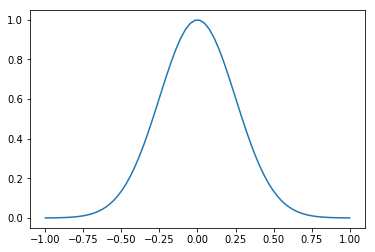

In [26]:
plt.plot(x,y)

In [35]:
from numpy.polynomial.chebyshev import chebfit, chebval

In [29]:
chebfit(x,y,n-1)

array([ 2.07001921e-01, -4.71273065e-16, -3.57501679e-01, -3.57196034e-16,
        2.35253003e-01,  4.24415618e-17, -1.22248676e-01, -1.99205481e-16,
        5.18799889e-02,  3.68971728e-16, -1.84886983e-02,  3.05186722e-16,
        5.65824299e-03, -1.09906472e-16, -1.51396937e-03, -6.28036983e-17,
        3.59350184e-04, -1.09906472e-16, -7.65686395e-05, -3.92523115e-17,
        1.47913056e-05,  8.63550852e-17, -2.61211150e-06, -5.18130511e-16,
        4.24692337e-07, -1.25607397e-16, -6.39574805e-08, -2.11962482e-16,
        8.96871173e-09,  7.85046229e-17, -1.17649988e-09,  1.09906472e-16,
        1.44957927e-10,  3.53270803e-16, -1.68361917e-11,  2.94392336e-16,
        1.84895854e-12,  5.10280049e-17, -1.92685672e-13, -1.33457859e-16,
        1.91786794e-14, -4.71027738e-17, -1.42289629e-15, -1.13831703e-16,
       -8.04672385e-17,  3.61121265e-16,  1.96261557e-17, -1.64859708e-16,
        3.06168029e-16,  5.49532361e-17, -6.35887446e-16,  2.51214793e-16,
        1.57009246e-16, -

We see that our coefficients get extremely small for this fit. In the paper, they suggest looking at grids of size $n=2^i+1$ (and fits of degree $n-1$) and increasing $i$ until the tail of the series is below machine precision, in this case about $10^{-15}$.

In [32]:
i = 3
while True:
    n = 2**i + 1
    x = chebnodes(-1,1,n)
    y = pdf(x)
    coeffs = chebfit(x,y,n-1)
    if max(np.abs(coeffs[-5:])) < 10**(-15):
        break
    i += 1

In [33]:
n

65

In [34]:
coeffs

array([ 2.07001921e-01,  1.64240866e-16, -3.57501679e-01,  7.30297505e-17,
        2.35253003e-01,  2.60472777e-16, -1.22248676e-01, -2.31260877e-16,
        5.18799889e-02, -1.03458813e-16, -1.84886983e-02, -3.35936852e-16,
        5.65824299e-03, -4.08662312e-16, -1.51396937e-03, -4.06532278e-16,
        3.59350184e-04, -6.42661805e-16, -7.65686395e-05,  7.30297505e-17,
        1.47913056e-05, -1.16847601e-16, -2.61211150e-06, -2.09351951e-16,
        4.24692337e-07,  4.64956078e-16, -6.39574812e-08, -9.85901632e-17,
        8.96871155e-09,  5.84238004e-17, -1.17650058e-09, -4.28441203e-16,
        1.44957891e-10, -2.53169802e-16, -1.68368337e-11, -2.87250352e-16,
        1.84931777e-12,  1.94746001e-16, -1.92954338e-13, -2.96987652e-16,
        1.90266843e-14,  2.33695202e-16, -2.55117262e-15,  3.29851040e-16,
        9.73730007e-17, -2.82381702e-16, -2.82381702e-16,  7.01085605e-16,
        1.31453551e-16,  1.67968426e-16, -3.50542803e-16,  9.73730007e-17,
       -6.03712604e-16, -

Let's look at the fit itself:

In [36]:
ycheb = chebval(x,coeffs)

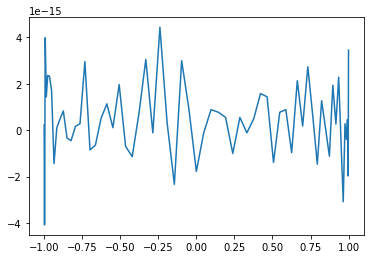

In [39]:
plt.plot(x,y-ycheb);

So error is down on the order of $10^{-15}$, as we hoped.

## Chebyshev Integration

There's a nice formula that allows for easy integration of a Chebyshev series. Blessedly, this is built-in to Numpy as `chebint`. Let's give it a try, and compare it to numerical integration.

In [40]:
from numpy.polynomial.chebyshev import chebint

In [42]:
int_coeffs = chebint(coeffs)

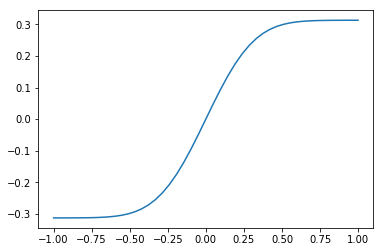

In [44]:
plt.plot(x,chebval(x,int_coeffs))

In [45]:
from scipy.integrate import quad
y = [quad(pdf,-1,x0)[0] for x0 in x]

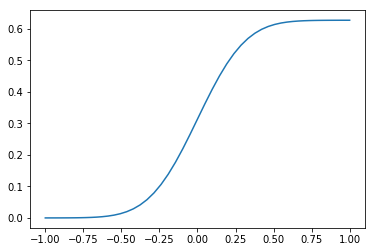

In [47]:
plt.plot(x,y)

Looks like `chebint` assumes we're integrating from zero. We can just subtract off the first term of the series in this case, although things might get more complicated when we go to work with intervals that are not $[-1,1]$.

In [48]:
ycheb = chebval(x,int_coeffs) - chebval(-1,int_coeffs)

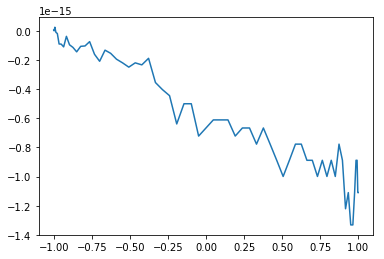

In [52]:
plt.plot(x,ycheb-y)

Error increases over the interval, although it's hard to say whether this is coming from the numerical quadrature or the Chebyshev approximation.

## On a general interval $[a,b]$

In [90]:
def pdf(x):
    return np.cos(x)**2

In [103]:
i = 3
while True:
    n = 2**i + 1
    x = chebnodes(-5,3,n)
    y = pdf(x)
    coeffs = chebfit(x,y,n-1)
    if max(np.abs(coeffs[-5:])) < 10**(-15):
        break
    i += 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RankWarning: The fit may be poorly conditioned
  


Why is the fit poorly conditioned? That is to say, **how does the grid size relate to the degree of the fit we're using?**

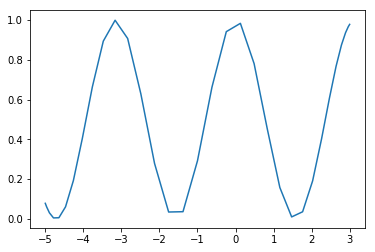

In [104]:
plt.plot(x,y)

In [105]:
coeffs

array([ 6.11945390e-01,  1.80251844e-14, -3.52834029e-01,  7.20096088e-14,
        3.39957198e-02, -3.23659985e-15, -1.20242897e-03, -2.80860645e-14,
        2.21795523e-05,  1.40828677e-14, -2.51538630e-07, -3.20592748e-15,
        1.93269523e-09,  4.17974462e-16, -1.07294430e-11, -3.36298757e-17,
        4.50561967e-14,  1.68118263e-18, -1.47867940e-16, -4.80306149e-20,
        3.77881131e-19,  4.53296883e-22, -4.67718047e-22,  1.68875031e-23,
       -4.19350795e-24, -6.51362171e-25,  2.46793916e-26,  8.58050029e-27,
        3.70539159e-28, -3.07556306e-29, -3.94702420e-30, -1.64033233e-31,
       -2.52286043e-33])

In [106]:
ycheb = chebval(x,coeffs)

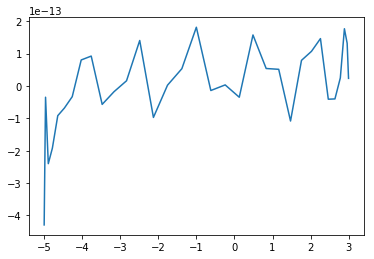

In [107]:
plt.plot(x,y-ycheb);

Hrm... error here is higher, even though our coefficients themselves are very low. **I wonder how we could control the error itself, rather than the coefficients.** (More on this below)

In [118]:
int_coeffs = chebint(coeffs)
y = [quad(pdf,-5,x0)[0] for x0 in x]
ycheb = chebval(x,int_coeffs) - chebval(-5,int_coeffs)

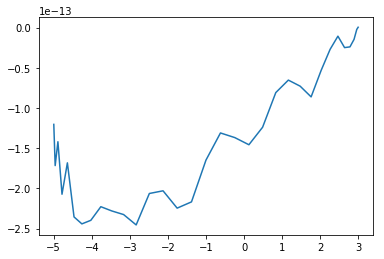

In [119]:
plt.plot(x,y-ycheb)

Okay, so it's that simple.